Import des librairies et données nécessaires à l'étude:
===

In [1]:
# Librairies de calcul
import pandas as pd
import numpy as np

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Option globale pour l'output display
pd.options.display.float_format = "{:.2f}".format

# Import des donnees
Liaison_df = pd.read_csv("liaison.csv", sep=";")
Erp_df = pd.read_csv("ERP.csv", sep=";")
Web_df = pd.read_csv("web.csv", sep=";")

Observation et nettoyage des Dataframes:
===

Liaison_df:
---

In [2]:
Liaison_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


**On devra faire attention ici certains product_id n'ont pas de correspondance dans id_web (a renommé plus tard "sku" pour garder la continuité avec le df web). En fait il s'agit des références non disponibles sur le site web, ce qui correspond à "0" dans la colonne onsale_web d'Erp_df.**

**De plus product_id est considéré comme un chiffre, on le veut en tant qu'objet.**

In [3]:
Liaison_df["product_id"] = Liaison_df.astype({"product_id":object})
Liaison_df = Liaison_df.rename(columns={"id_web":"sku"})

Erp_df:
---

In [4]:
Erp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


**Ici aucune valeur manquante, par contre:**
- **product_id considéré comme un int on le veut en tant qu'object, c'est une erreure courante.**

*onsale_web et stock_status peuvent être considérés comme booléens (onsale_web : 1 = en vente sur le site, 0= pas en vente sur le site ; outofstock/onstock parlent d'eux-mêmes) mais pour sont conservés en tant qu'object pour l'instant.*

In [5]:
Erp_df["product_id"] = Erp_df.astype({"product_id":object})

Web_df:
---

In [6]:
Web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sku                    1428 non-null   object 
 1   virtual                1513 non-null   int64  
 2   downloadable           1513 non-null   int64  
 3   rating_count           1513 non-null   int64  
 4   average_rating         1430 non-null   float64
 5   total_sales            1430 non-null   float64
 6   tax_status             716 non-null    object 
 7   tax_class              0 non-null      float64
 8   post_author            1430 non-null   float64
 9   post_date              1430 non-null   object 
 10  post_date_gmt          1430 non-null   object 
 11  post_content           0 non-null      float64
 12  post_title             1430 non-null   object 
 13  post_excerpt           716 non-null    object 
 14  post_status            1430 non-null   object 
 15  comm

**Ici on a beaucoup de colonnes qui posent potentiellement problème:**
- **post_date, post_date_gmt, post_modified et post_modified_gmt sont des datetimes et non des object.**
- *virtual, downlodable, rating_count, average_rating, post_parent, menu_order et comment_count sont toujours vides ou égales à zéro, sont elles vraiment utiles ? Nous les gardons pour le moment. Idem taxe_class, post_content, post_password et post_content_filtered sont toujours vides.*
- *Post_status comment_status, ping_status, post_type et post_mime_type sont comme précédemment des booléens en quelque sorte mais restent pour l'instant des object, il peut être intéressant à l'avenir de les modifier selon leur importance.*
- **post_author n'est pas un float mais un object.**

In [7]:
Web_df["post_date"] = pd.to_datetime(Web_df["post_date"], yearfirst= True)
Web_df["post_date_gmt"] = pd.to_datetime(Web_df["post_date_gmt"], yearfirst= True)
Web_df["post_modified"] = pd.to_datetime(Web_df["post_modified"], yearfirst= True)
Web_df["post_modified_gmt"] = pd.to_datetime(Web_df["post_modified_gmt"], yearfirst= True)
Web_df["post_author"] = Web_df.astype({"post_author":object})

Missions:
===

Rapprocher les exports ERP et Web via Liaison:
---

**Il s'agit ici de faire une jointure, il fautre prendre en compte le fait que les product_id des ERP n'aient pas toujours une correspondance dans les sku des exports Web.**
On commence par une première jointure Erp/Liaison, avec product_Id en clé puisque dans les deux df ont à le même nombre de références uniques. Puis le df intermédiaire est merge à son tour avec Web_df, on utilise les sku en clé. C'est ici qu'il faut faire attention aux références non vendues sur le site.


In [8]:
#Ducplicats:
Duplicated_df = Web_df.loc[Web_df.duplicated(subset="sku", keep="last")==True].sort_values("post_type")

*keep = False garde tous les tuples, il est donc normal d'avoir le même nombre, si on keep="last" après avoir trié par post_type, 'product' arrivant toujours en dernier on ne garde  en théorie que les bouteilles. En pratique des NaN sont placés en fin de classement, on aura donc certains SKU conservés sans les informations nécessaires si on supprime directement via cette méthode. On choisit de sélectionner par type de produits.*

*Toutes les lignes où SKU = NaN sont complètement vides donc à enlever, excepté deux lignes vides concernant "Pierre Jean Villa Côte Rôtie Fongeant 2017" et "Pierre Jean Villa Condrieu Jardin Suspendu 2018" il faut voir avec le service concerné si ces lignes doivent être conservées et complétées ou non (produits vendus en boutique ? sur le site? en stock ?).*

In [22]:
#On merge (inner) Erp et Liaison dans un dataframe intermediaire:
Interm_df = pd.merge(Erp_df, Liaison_df, on=["product_id"])

#On merge (right) le dataframe intermediaire avec Web:
Complet_df = pd.merge(Interm_df, Web_df, how="right",on=["sku"])

#On ne garde que les articles (on enlève les attachements des postes type images et autres):
Complet_df = Complet_df[Complet_df["post_type"]=="product"]

**On fait en premier lieu une jointure interne (on utilise l'intersection des deux clés pour effectuer la jointure), on a le même nombre de product_id le résultat serait donc le même avec une outer joint (on utilise l'union des deux clés pour effectuer la jointure).**
**Ensuite on fait une jointure par la droite pour rapprocher les lignes désignées par un sku tout en conservant tous les produits(la jointure est réalisée en utilisant seulement la clé de la dernière table).**

Chiffre d'affaire par produits:
---

In [23]:
# Creation d'une colonne contenant le chiffre d'affaire par produits:
Complet_df["ca_product"] = Complet_df["price"]*Complet_df["total_sales"]

print(Complet_df.groupby("post_title")[["ca_product"]].prod())

                                                    ca_product
post_title                                                    
Agnès Levet Côte Rôtie Améthyste 2017                   164.80
Agnès Levet Côte Rôtie Maestria 2017                    165.00
Agnès Levet Côte Rôtie Péroline 2017                    171.00
Alain Graillot Crozes-Hermitage Blanc 2018              244.00
Alain Graillot Crozes-Hermitage Rouge 2017              146.40
...                                                        ...
Zind-Humbrecht Pinot Gris Roche Calcaire 2017             0.00
Zind-Humbrecht Riesling Clos Windsbuhl 2014               0.00
Zind-Humbrecht Riesling Grand Cru Rangen De Tha...        0.00
Zind-Humbrecht Riesling Herrenweg de Turckheim ...       63.40
Zind-Humbrecht Zind 2017                                154.20

[713 rows x 1 columns]


Chiffre d'affaire totaux:
---

In [24]:
# Chiffre d'affaire global:
Ca_Tot = sum(Complet_df["ca_product"])

print("Le chiffre d'affaire total est de", Ca_Tot, "€")

Le chiffre d'affaire total est de 70568.6 €


In [12]:
# Chiffre d'affaire en ligne total:
Ca_Web = sum(Complet_df.loc[(Complet_df["onsale_web"]==1),"price"]
            *Complet_df.loc[(Complet_df["onsale_web"]==1),"total_sales"])

print("Le chiffre d'affaire en ligne total est de", Ca_Web, "€")

Le chiffre d'affaire en ligne total est de 70568.6 €


**On remarque que les deux expressions donnent le même résulat, ce n'est dû qu'au fait que les ventes en boutiques ne sont pour le moment pas comptabilisées dans notre dataframe** (*total_sales toujours nulles*) **mais si nous complétons notre df en ajoutant ces données alors la première expression ne correspondra plus au chiffre d'affaire total des ventes en ligne mais au chiffre d'affaire globale.**

**Six produits vendus sur internet n'ont pas de SKU (ils sont tous out of stock mais tous les produits out of stock ne sont 
pas NaN pour leur SKU) c'est pour cela que nous n'avons pas utilisé la condition "avoir un SKU" comme contrainte dans le calcul du chiffre d'affaire en ligne, cependant il faudrait se pencher sur ce fait pour le corriger au plus vite, les produits web ne pouvant pas rester sans identifiants au risque d'entrainer des erreurs.**


Analyse des prix et représentation graphique: (outliers)
---

In [13]:
Complet_df[["price"]].describe()


,price
count,896.00
mean,32.80
std,26.40
min,5.20
25%,15.30
50%,25.90
75%,42.70
max,225.00


In [14]:
print("Le mode est de", Complet_df["price"].mode())
print("La variance est de", round(Complet_df["price"].var(ddof=0),2))
print("Le Skewness est de", round(Complet_df["price"].skew(),2))

Le mode est de 0   45.00
dtype: float64
La variance est de 696.25
Le Skewness est de 2.6


**La méthode .describe nous donne un résumé statistique basique de la colonne price de notre dataframe.**
* Nous avons donc 896 valeurs avec 5,20€ pour le prix minimum et 225€ pour le prix maximum.
* Nous avons aussi les premier et troisème percentiles ainsi que la médiane (second percentil, 50%) à 25,90€.
* l'écart type est de 26,40€
* La moyenne de 32,80€. On note qu'elle est différente de la médiane.
* On calcule le mode et la variance empirique en plus qui sont réspectivement de 45€ et de 696,25€² ce sont des mesures d'utilité limitée si ce n'est pour d'autres calculs.
* La mesure du Skewness de 2,6 est bien supérieure à zéro et nous indique que nos valeurs sont étalées vers la droite, donc vers les prix les plus élevés. La distribution étant assymétrique on ne peut pas caluler le Kurtosis.

Verifions cela de manière plus graphique:

*Pour rappel:*
* *mode = valeur la plus fréquente*
* *moyenne= somme des valeurs divisée par leur nombre, robuste aux outliers*
* *médiane= autant de valeur au-dessus qu'en-dessous*

Text(0.5, 1.0, 'Répartition des prix')

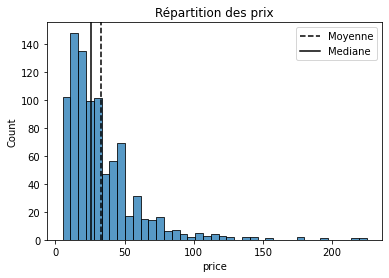

In [15]:
mean = Complet_df["price"].mean()
median = Complet_df["price"].median()

#Representation de la repartition des prix en histogramme:
sns.histplot(data=Complet_df["price"])
plt.axvline(mean, color="black", linestyle="--")
plt.axvline(median, color="black", linestyle="-")
plt.legend({"Moyenne":mean,"Mediane":median})
plt.title("Répartition des prix")


**L'histogramme de la répartition des prix correspond visuellement à ce qui est attendu même min/max, la moyenne et la médiane aussi. On voit que la médiane est décalée sur la gauche de notre graphique, les premiers prix sont donc plus fréquents dans notre boutique que les plus élevé. La mesure empirique du Skweness est confirmée puisqu'on voit que la répartition est dissymétrique en faveur de la droite. Visuellement et sans avoir encore de confirmation tangible il semblerait que les outliers se retrouvent plutôt parmi les prix élevés.**

In [16]:
# Detection numerique des outliers:
Q1 = Complet_df["price"].quantile(q=0.25, interpolation="midpoint")
Q3 = Complet_df["price"].quantile(q=0.75, interpolation="midpoint")
Iq = Q3 - Q1

Lim_Outliers_Inf = Q1-1.5*Iq
Lim_Outliers_Sup = Q3+1.5*Iq

Outliers_Inf = Complet_df["price"] < Lim_Outliers_Inf
Outliers_Sup = Complet_df["price"] > Lim_Outliers_Sup

print("Limite pour les outliers inferieurs:\n", round(Lim_Outliers_Inf,2))
print("Les index des outliers inferieurs sont:\n", np.where(Outliers_Inf)[0])

print("Limite pour les outliers superieurs:\n", round(Lim_Outliers_Sup,2))
print("Les index des outliers superieurs sont:\n", np.where(Outliers_Sup)[0])
print("\n",Complet_df.loc[(Complet_df["price"]>84.05),("price","post_title")])


Limite pour les outliers inferieurs:
 -25.95
Les index des outliers inferieurs sont:
 []
Limite pour les outliers superieurs:
 84.05
Les index des outliers superieurs sont:
 [ 64  66 200 202 206 219 220 222 223 228 381 382 426 431 432 437 438 448
 459 476 484 539 550 567 575 684 693 735 769 784 785 786 824 829 830 835
 836 837 838 839]

       price                                         post_title
64   100.00  Zind-Humbrecht Riesling Grand Cru Rangen De Th...
66    88.40  Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...
382  225.00     Champagne Egly-Ouriet Grand Cru Millésimé 2008
384  126.50     Champagne Egly-Ouriet Grand Cru Blanc de Noirs
388   85.60  Champagne Larmandier-Bernier Grand Cru Les Che...
401  176.00                               Cognac Frapin VIP XO
402  108.50              Cognac Frapin Château de Fontpinot XO
404  157.00  Cognac Frapin Château de Fontpinot 1989 20 Ans...
405  104.00                          Cognac Frapin Cigar Blend
774  109.60  Château de Meursa

**Les valeurs en dessous de Q1- 1,5 x IQ et au-dessus de Q3 + 1,5 x IQ qui seront considérée comme de outliers.**
*(avec Q1 = premier quantile, IQ = écart interquantile et Q3 = troisième quantile)*


* **La limite inférieure étant négative (-25,95) il est logique qu'aucun outlier inférieur n'existe (un prix ne peut pas être négatif et notre valeur de prix minimale est de 5,20€). On vérifie tout de même en affichant les index pour lesquels l'affirmation serait juste (True).**

* **La limite supérieure est elle de 84,05€ sachant que la valeur maximale est de 225€ il est évident qu'il y a au moins un outlieur supérieur, on doit donc retourner les index des tuples pour lesquels l'affirmation est juste. Il y a 41 références concernées.**

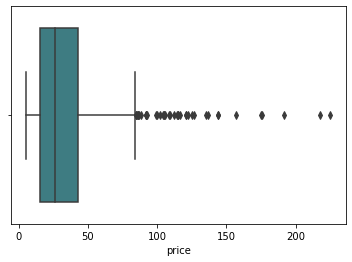

In [17]:
# Representation graphique en boxplot:
Boxplot = sns.boxplot(x=Complet_df["price"],palette="crest")

**On retrouve nos Q1, Q3 et la médiane, les 41 outliers au-dessus de Q3 et leur position en fonction de leur prix.**

Autres informations:
---

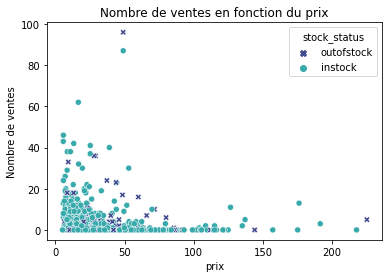

In [18]:
#Representation graphique en nuage de points:
sns.scatterplot(data=Complet_df,
                x="price",
                y="total_sales",
                hue="stock_status",
                style="stock_status",
                palette="mako",
                hue_order=("outofstock","instock"))
plt.xlabel("prix")
plt.ylabel("Nombre de ventes")
plt.title("Nombre de ventes en fonction du prix")
plt.show()


**Bien que ce graphique soit moyennement lisible en détails dans les catégories de prix les moins élevées avec des ventes faibles, il permet tout de même de s'apercevoir que nous sommes à court de notre bestseller (96 ventes à 49€ pour le Champagne Gosset Grand Blanc de Blancs) ainsi que pour notre bouteille la plus chère.**

In [19]:
Best_Seller_Web = Complet_df.loc[(Complet_df["onsale_web"]==1),("sku",
                                                                "total_sales",
                                                                "price",
                                                                "ca_produit",
                                                                "stock_status")
                                ]

print(Best_Seller_Web.nlargest(10,"total_sales"))

        sku  total_sales  price  ca_produit stock_status
377    7818        96.00  49.00     4704.00   outofstock
72     1662        87.00  49.00     4263.00      instock
31    16416        62.00  16.60     1029.20      instock
120   16295        46.00   5.80      266.80      instock
98    16210        43.00   5.70      245.10      instock
110   16189        42.00  13.30      558.60      instock
3381  16580        41.00  25.20     1033.20      instock
70      304        40.00  39.00     1560.00      instock
1599     38        38.00   8.60      326.80      instock
3264  16264        38.00  10.90      414.20      instock


**Ce tableau nous permet d'identifier nos produits les plus vendus sur le web ainsi que leur disponibilité, il nous confirme que le produit le plus vendu est actuellement en rupture de stock. C'est un résumé du graphique précédent.**

In [20]:
# Correlation entre le prix et le nombre de ventes:
print("Le coefficiant de correlation de Pearson vaux",
      round(Complet_df["price"].corr(Complet_df["total_sales"]),2))

Le coefficiant de correlation de Pearson vaux -0.13


*Le coeficiant de corrélation de Pearson est de -0,13, donc inférieur à zéro indiquant une relation négative entre le prix et les ventes, cependant, la valeur absolue du r reste proche de zéro, la relation n'est donc pas très marquée.*


**Attention cependant, ce teste n'est que très superficiel, la normalité de la répartition des prix ainsi que la significativité de la mesure du r restent à être fait si les analyses sont demandées à l'avenir.**